
## **Libraries** 

In [34]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter
import numpy as np
import os
from PIL import Image
import random

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_value = 42 
set_seed(seed_value)

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls_name in self.classes:
            cls_path = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[cls_name])
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]   
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  

        if self.transform:
            image = self.transform(image)
        #print(image)
        return image, label


In [4]:
data_dir = r"C:\Users\Gell G15\OneDrive\Desktop\Cognitive project -fire detection\Fire_detection_set"

image_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

full_dataset = CustomImageDataset(root_dir=data_dir, transform=transform)

labels = [label for _, label in full_dataset]
class_counts = Counter(labels)
print('Class Distribution:', class_counts)

Class Distribution: Counter({1: 1333, 0: 1018})


In [ ]:
# Consider using torch's random_split for cleaner code
from torch.utils.data import random_split

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Use random_split with generator for reproducibility
generator = torch.Generator().manual_seed(42)
train_subset, validation_subset, test_subset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=generator
)

#Create DataLoaders with consistent naming
batch_size = 32
train_data_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print('Class Distribution of Training Set:', Counter([full_dataset.labels[i] for i in train_subset.indices]))
print('Validation Set Class Distribution:', Counter([full_dataset.labels[i] for i in validation_subset.indices]))
print('Test Set Class Distribution:', Counter([full_dataset.labels[i] for i in test_subset.indices]))


Class Distribution of Training Set: Counter({1: 1056, 0: 824})
Validation Set Class Distribution: Counter({1: 134, 0: 101})
Test Set Class Distribution: Counter({1: 143, 0: 93})


In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Changed to 1 output for binary classification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print('The pre-trained ResNet18 model was loaded and its last layer was updated.')
print(model)

c:\Users\Gell G15\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gell G15\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The pre-trained ResNet18 model was loaded and its last layer was updated.
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

"from PIL import Image\nimport torch\nimport torchvision.transforms as transforms\n\ndef predict_image(image_path, model, transform, device):\n    image = Image.open(image_path).convert('RGB')\n    image = transform(image).unsqueeze(0).to(device)\n\n    model.eval()\n    with torch.no_grad():\n        outputs = model(image)\n        _, predicted = torch.max(outputs, 1)\n        confidence = torch.nn.functional.softmax(outputs, dim=1)[0][predicted].item()\n        \n    return predicted.item(), confidence"

In [7]:
criterion = nn.BCEWithLogitsLoss()  # Loss Function: Binary Cross Entropy with Logits
learning_rate = 0.001  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print('The loss function and optimization algorithm are defined.')

The loss function and optimization algorithm are defined.


## **Training Model**

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    best_val_loss = float('inf')  # Keeps track of best validation loss
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
            # Calculate training accuracy
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_predictions / total_samples
        history['train_loss'].append(epoch_loss)

        model.eval()  
        val_loss = 0.0
        correct_predictions_val = 0
        total_samples_val = 0

        with torch.no_grad():  
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() * inputs.size(0)
                probabilities = torch.sigmoid(outputs)
                predictions = (probabilities > 0.5).float()
                correct_predictions_val += (predictions == labels).sum().item()
                total_samples_val += labels.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_predictions_val / total_samples_val
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'Fire_detection_model.pth') 
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping applied! Best validation loss: {best_val_loss:.4f}')
                break

    model.load_state_dict(torch.load('Fire_detection_model.pth'))
    return model, history

num_epochs = 20  
patience = 5    
trained_model, history = train_model(model, train_data_loader, validation_data_loader, criterion, optimizer, num_epochs, patience)

Epoch [1/20], Train Loss: 0.0643, Train Accuracy: 0.9798, Validation Loss: 0.1568, Validation Accuracy: 0.9660
Epoch [2/20], Train Loss: 0.0568, Train Accuracy: 0.9777, Validation Loss: 0.1441, Validation Accuracy: 0.9617
Epoch [3/20], Train Loss: 0.0586, Train Accuracy: 0.9819, Validation Loss: 0.1045, Validation Accuracy: 0.9617
Epoch [4/20], Train Loss: 0.0467, Train Accuracy: 0.9856, Validation Loss: 0.1103, Validation Accuracy: 0.9617
Epoch [5/20], Train Loss: 0.0325, Train Accuracy: 0.9899, Validation Loss: 0.3282, Validation Accuracy: 0.9277
Epoch [6/20], Train Loss: 0.0389, Train Accuracy: 0.9851, Validation Loss: 0.1540, Validation Accuracy: 0.9362
Epoch [7/20], Train Loss: 0.0305, Train Accuracy: 0.9888, Validation Loss: 0.0616, Validation Accuracy: 0.9830
Epoch [8/20], Train Loss: 0.0276, Train Accuracy: 0.9888, Validation Loss: 0.1823, Validation Accuracy: 0.9702
Epoch [9/20], Train Loss: 0.0231, Train Accuracy: 0.9910, Validation Loss: 0.1445, Validation Accuracy: 0.9745
E

Test Loss: 0.0727
Test Accuracy: 0.9661
Precision: 0.9530
Recall: 0.9930
F1-Score: 0.9726

Classification Report:
              precision    recall  f1-score   support

        Fire       0.99      0.92      0.96        93
     No Fire       0.95      0.99      0.97       143

    accuracy                           0.97       236
   macro avg       0.97      0.96      0.96       236
weighted avg       0.97      0.97      0.97       236



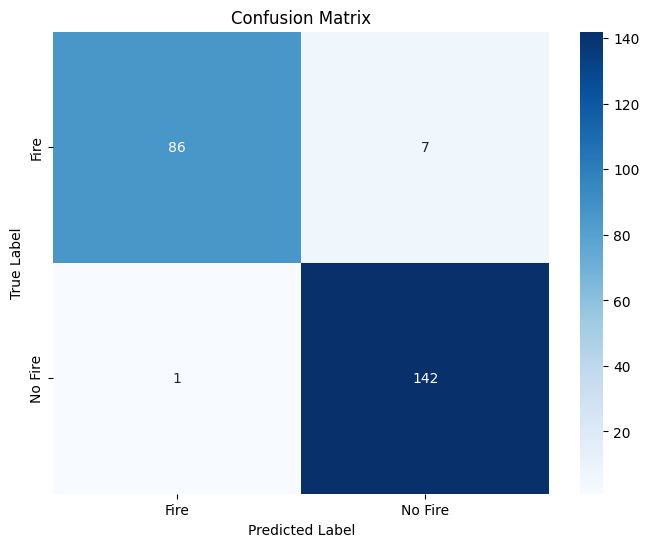

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
            
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
            all_probabilities.extend(probabilities.cpu().numpy().flatten())

    #_______________________________________________Calculate metrics_________________________________________________________
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct_predictions / total_samples
    
    from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)

    #_______________________________________________Print results_________________________________________________________
    print(f'Test Loss: {avg_test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    
    print('\nClassification Report:')
    print(classification_report(all_labels, all_predictions, target_names=['Fire', 'No Fire']))

    #print('\nConfusion Matrix:')
    cm = confusion_matrix(all_labels, all_predictions)
    #print(cm)

    #__________________________________________________PLOT CONFUSION MATRIX_______________________________________________________

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fire', 'No Fire'], 
                yticklabels=['Fire', 'No Fire'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return all_probabilities, all_labels, all_predictions



# Run evaluation
test_probabilities, test_labels, test_predictions = evaluate_model(trained_model, test_data_loader, criterion)

In [17]:
# Load the saved model - CORRECTED VERSION
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Changed to 1 output neuron for binary classification
model.load_state_dict(torch.load('Fire_detection_model.pth'))
model.to(device)
model.eval()

print('Model loaded successfully!')
print(f'Model architecture: {model}')
print(f'Model device: {next(model.parameters()).device}')

Model loaded successfully!
Model architecture: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [30]:
# Make sure you have the predict_image function defined
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_image(image_path, model, transform, device):
    try:
        # Open and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            outputs = model(image)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).float()
            # Confidence calculation adjusted for inverted labels
            confidence = probabilities.item() if predicted.item() == 0 else 1 - probabilities.item()
            
        return predicted.item(), confidence
        
    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, None

# Define your transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Example with a specific image
image_path = r"C:\Users\Gell G15\OneDrive\Desktop\Cognitive project -fire detection\Fire_detection_set\Neutral\6.jpg"

# Make prediction
predicted_class, confidence = predict_image(image_path, model, transform, device)

if predicted_class is not None:
    class_names = ['Fire', 'No Fire']  # 0 = Fire, 1 = No Fire
    print(f"Predicted Class: {class_names[int(predicted_class)]} ({predicted_class})")
    print(f"Confidence: {confidence:.2%}")
    
    # Additional interpretation
    if predicted_class == 0:
        print("🚨 Fire detected!")
    else:
        print("✅ No fire detected.")
else:
    print("Prediction failed.")

Predicted Class: No Fire (1.0)
Confidence: 0.00%
✅ No fire detected.
